# Imports

In [23]:
import pandas as pd 
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from functools import reduce

from sql import config
from sqlalchemy import create_engine, text

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from prophet import Prophet

# Preprocessing 

In [3]:
data_files = {
    "building_permits": "/Users/olivia.pacalau/Desktop/ZehnderAssignment/GERMANYBUIPER.csv",
    "price_to_rent": "/Users/olivia.pacalau/Desktop/ZehnderAssignment/BDPRR.csv",
    "construction_output": "/Users/olivia.pacalau/Desktop/ZehnderAssignment/GermanyConOut.csv",
    "residential_prices": "/Users/olivia.pacalau/Desktop/ZehnderAssignment/BDRPP.csv"
}

def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)

    # Promote top row as headers
    if df.columns[0] == df.iloc[0, 0]:
        df.columns = df.iloc[0]
        df = df.drop(index=0)

    # Clean column names
    df.columns = [str(col).strip().lower().replace(" ", "_") for col in df.columns]

    # Convert to datetime
    for col in ['datetime', 'lastupdate']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            
    # Show pretty summary
    print(f"\n Summary for **{name}**")
    
    # Value stats
    if 'value' in df.columns:
        stats = df['value'].describe()
        print(f"""\
- Count: {int(stats['count'])}
- Mean: {stats['mean']:.2f}
- Std Dev: {stats['std']:.2f}
- Min: {stats['min']:.2f}
- Max: {stats['max']:.2f}
- Median: {df['value'].median():.2f}
- Missing values: {df['value'].isnull().sum()}""")

    # Datetime range
    if 'datetime' in df.columns:
        print(f"- Date Range: {df['datetime'].min().date()} → {df['datetime'].max().date()}")

    return df

# Load all data
data = {}
for name, path in data_files.items():
    data[name] = load_and_clean_data(path)



 Summary for **building_permits**
- Count: 69
- Mean: 23774.81
- Std Dev: 5695.11
- Min: 11616.00
- Max: 36606.00
- Median: 24941.00
- Missing values: 0
- Date Range: 2019-01-31 → 2024-09-30

 Summary for **price_to_rent**
- Count: 22
- Mean: 133.96
- Std Dev: 9.82
- Min: 119.42
- Max: 150.65
- Median: 131.76
- Missing values: 0
- Date Range: 2019-03-31 → 2024-06-30

 Summary for **construction_output**
- Count: 69
- Mean: -0.30
- Std Dev: 4.76
- Min: -12.90
- Max: 12.40
- Median: -0.40
- Missing values: 0
- Date Range: 2019-01-31 → 2024-09-30

 Summary for **residential_prices**
- Count: 22
- Mean: 3.63
- Std Dev: 7.59
- Min: -10.20
- Max: 12.77
- Median: 6.22
- Missing values: 0
- Date Range: 2019-03-31 → 2024-06-30


# SQL

In [4]:
# Create SQLite database
conn = sqlite3.connect("market_data.db")

for table_name, df in data.items():
    df.to_sql(table_name, conn, index=False, if_exists='replace')
    print(f"Loaded '{table_name}' into SQLite")

Loaded 'building_permits' into SQLite
Loaded 'price_to_rent' into SQLite
Loaded 'construction_output' into SQLite
Loaded 'residential_prices' into SQLite


In [5]:
%load_ext sql
%sql sqlite:///market_data.db
config.style = 'DEFAULT'

## Monthly table creation

In [6]:
# Create the Monthly Unified Table (building_permits and construction_output only)

bp = data["building_permits"][["datetime", "value"]].copy()
bp = bp.rename(columns={"value": "building_permits"})

co = data["construction_output"][["datetime", "value"]].copy()
co = co.rename(columns={"value": "construction_output"})

dfs_monthly = [bp, co]

unified_monthly = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), dfs_monthly)
unified_monthly = unified_monthly.sort_values("datetime").reset_index(drop=True)


unified_monthly.to_sql("market_data_monthly", conn, index=False, if_exists="replace")
print("Saved 'market_data_monthly' to SQLite")

Saved 'market_data_monthly' to SQLite


Mock SQL Schema for market_data_monthly

```sql
CREATE TABLE market_data_monthly (
    datetime DATE PRIMARY KEY,
    building_permits INTEGER,
    construction_output REAL
);

## Quarterly Table Creation

In [7]:
# First, resample monthly data (building_permits, construction_output) to quarterly
monthly_data = ['building_permits', 'construction_output']
data_quarterly = {}

for name, df in data.items():
    if name in monthly_data:
        # Set datetime as index
        df = df.set_index('datetime')

        # Separate numeric and non-numeric columns
        numeric_cols = df.select_dtypes(include='number').columns
        non_numeric_cols = df.select_dtypes(exclude='number').columns

        # Resample numeric columns with mean
        df_num = df[numeric_cols].resample('QE').mean().round(2)

        # Resample non-numeric columns with last known value
        df_meta = df[non_numeric_cols].resample('QE').last()

        # Combine
        df_q = pd.concat([df_num, df_meta], axis=1).reset_index()

        data_quarterly[name] = df_q
        print(f"Resampled '{name}' to quarterly")
    else:
        # Already quarterly – standardize format
        df_q = df.copy()
        data_quarterly[name] = df_q

# Create the quarterly unified table
bp = data_quarterly["building_permits"][["datetime", "value"]].copy()
bp = bp.rename(columns={"value": "building_permits"})

pr = data_quarterly["price_to_rent"][["datetime", "value"]].copy()
pr = pr.rename(columns={"value": "price_to_rent_ratio"})

co = data_quarterly["construction_output"][["datetime", "value"]].copy()
co = co.rename(columns={"value": "construction_output"})

rp = data_quarterly["residential_prices"][["datetime", "value"]].copy()
rp = rp.rename(columns={"value": "residential_prices"})

dfs = [bp, pr, co, rp]
unified_quarterly = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), dfs)

unified_quarterly = unified_quarterly.sort_values("datetime").reset_index(drop=True)

unified_quarterly.to_sql("market_data_quarterly", conn, index=False, if_exists="replace")
print("Saved 'market_data_quarterly' to SQLite")

Resampled 'building_permits' to quarterly
Resampled 'construction_output' to quarterly
Saved 'market_data_quarterly' to SQLite


Mock SQL Schema for 'market_data_quarterly'
```sql
CREATE TABLE market_data_quarterly (
    datetime DATE PRIMARY KEY,
    building_permits REAL,
    price_to_rent_ratio REAL,
    construction_output REAL,
    residential_prices REAL
);


## Yearly Table Creation

In [8]:
data_yearly = {}

for name, df in data_quarterly.items():
    df = df.set_index('datetime')

    # Resample numeric columns with mean
    numeric_cols = df.select_dtypes(include='number').columns
    df_num = df[numeric_cols].resample('YE').mean().round(2)

    # Metadata columns (e.g., country, symbol, etc.)
    non_numeric_cols = df.select_dtypes(exclude='number').columns
    df_meta = df[non_numeric_cols].resample('YE').last()

    # Combine
    df_y = pd.concat([df_num, df_meta], axis=1).reset_index()

    data_yearly[name] = df_y
    print(f"Converted '{name}' to yearly")

# Create the yearly unified table
bp_y = data_yearly["building_permits"][["datetime", "value"]].rename(
    columns={"value": "building_permits"})

pr_y = data_yearly["price_to_rent"][["datetime", "value"]].rename(
    columns={"value": "price_to_rent_ratio"})

co_y = data_yearly["construction_output"][["datetime", "value"]].rename(
    columns={"value": "construction_output"})

rp_y = data_yearly["residential_prices"][["datetime", "value"]].rename(
    columns={"value": "residential_prices"})

dfs_y = [bp_y, pr_y, co_y, rp_y]
unified_yearly = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), dfs_y)

unified_yearly = unified_yearly.sort_values("datetime").reset_index(drop=True)

unified_yearly.to_sql("market_data_yearly", conn, index=False, if_exists="replace")
print("Saved 'market_data_yearly' to SQLite")

Converted 'building_permits' to yearly
Converted 'price_to_rent' to yearly
Converted 'construction_output' to yearly
Converted 'residential_prices' to yearly
Saved 'market_data_yearly' to SQLite


Mock SQL Schema for 'market_data_yearly'
```sql
CREATE TABLE market_data_yearly (
    datetime DATE PRIMARY KEY,
    building_permits REAL,
    price_to_rent_ratio REAL,
    construction_output REAL,
    residential_prices REAL
);


## #1 Query: Quarter-over-quarter growth

In [9]:
query_qoq = """
SELECT
    STRFTIME('%Y', datetime) || 'Q' || 
        ((CAST(STRFTIME('%m', datetime) AS INTEGER) - 1) / 3 + 1) AS quarter,

    ROUND(building_permits, 2) AS current_permits,
    ROUND(LAG(building_permits) OVER (ORDER BY datetime), 2) AS previous_permits,
    ROUND(
        (building_permits - LAG(building_permits) OVER (ORDER BY datetime)) * 100.0
        / LAG(building_permits) OVER (ORDER BY datetime), 2
    ) AS permits_qoq_pct,

    ROUND(residential_prices, 2) AS current_prices,
    ROUND(LAG(residential_prices) OVER (ORDER BY datetime), 2) AS previous_prices,
    ROUND(
        (residential_prices - LAG(residential_prices) OVER (ORDER BY datetime)) * 100.0
        / LAG(residential_prices) OVER (ORDER BY datetime), 2
    ) AS prices_qoq_pct,

    ROUND(price_to_rent_ratio, 2) AS current_ratio,
    ROUND(LAG(price_to_rent_ratio) OVER (ORDER BY datetime), 2) AS previous_ratio,
    ROUND(
        (price_to_rent_ratio - LAG(price_to_rent_ratio) OVER (ORDER BY datetime)) * 100.0
        / LAG(price_to_rent_ratio) OVER (ORDER BY datetime), 2
    ) AS ratio_qoq_pct,

    ROUND(construction_output, 2) AS current_output,
    ROUND(LAG(construction_output) OVER (ORDER BY datetime), 2) AS previous_output,
    ROUND(
        (construction_output - LAG(construction_output) OVER (ORDER BY datetime)) * 100.0
        / LAG(construction_output) OVER (ORDER BY datetime), 2
    ) AS output_qoq_pct

FROM market_data_quarterly
ORDER BY datetime;
"""

df_qoq = pd.read_sql(query_qoq, conn)
df_qoq.to_sql("market_data_qoq", conn, index=False, if_exists="replace")
print("Saved 'market_data_qoq' to SQLite")

print("Preview of QoQ table:")
display(df_qoq.head())

Saved 'market_data_qoq' to SQLite
Preview of QoQ table:


,quarter,current_permits,previous_permits,permits_qoq_pct,current_prices,previous_prices,prices_qoq_pct,current_ratio,previous_ratio,ratio_qoq_pct,current_output,previous_output,output_qoq_pct
0,2019Q1,22344.67,NaN,NaN,5.34,NaN,NaN,119.42,NaN,NaN,6.97,NaN,NaN
1,2019Q2,26055.33,22344.67,16.61,5.94,5.34,11.24,121.35,119.42,1.62,3.20,6.97,-54.09
2,2019Q3,26936.67,26055.33,3.38,5.27,5.94,-11.28,122.13,121.35,0.64,2.57,3.20,-19.69
3,2019Q4,30623.67,26936.67,13.69,6.51,5.27,23.53,124.53,122.13,1.97,1.83,2.57,-28.79
4,2020Q1,23654.33,30623.67,-22.76,7.40,6.51,13.67,126.49,124.53,1.57,6.40,1.83,249.73


## #2 Query: Year-to-year growth

In [10]:
query_yoy = """
WITH yearly AS (
    SELECT
        CAST(STRFTIME('%Y', datetime) AS INTEGER) AS year,
        building_permits,
        residential_prices,
        price_to_rent_ratio,
        construction_output
    FROM market_data_yearly
),
yoy AS (
    SELECT
        curr.year,
        ROUND(curr.building_permits, 2) AS current_permits,
        ROUND(prev.building_permits, 2) AS previous_permits,
        ROUND((curr.building_permits - prev.building_permits) * 100.0 / prev.building_permits, 2) AS permits_yoy_pct,

        ROUND(curr.residential_prices, 2) AS current_prices,
        ROUND(prev.residential_prices, 2) AS previous_prices,
        ROUND((curr.residential_prices - prev.residential_prices) * 100.0 / prev.residential_prices, 2) AS prices_yoy_pct,

        ROUND(curr.price_to_rent_ratio, 2) AS current_ratio,
        ROUND(prev.price_to_rent_ratio, 2) AS previous_ratio,
        ROUND((curr.price_to_rent_ratio - prev.price_to_rent_ratio) * 100.0 / prev.price_to_rent_ratio, 2) AS ratio_yoy_pct,

        ROUND(curr.construction_output, 2) AS current_output,
        ROUND(prev.construction_output, 2) AS previous_output,
        ROUND((curr.construction_output - prev.construction_output) * 100.0 / prev.construction_output, 2) AS output_yoy_pct
    FROM yearly curr
    JOIN yearly prev ON curr.year = prev.year + 1
)
SELECT * FROM yoy
ORDER BY year;
"""

df_yoy = pd.read_sql(query_yoy, conn)
df_yoy.to_sql("market_data_yoy", conn, index=False, if_exists="replace")
print("Saved 'market_data_yoy' to SQLite")

print("Preview of YoY table:")
display(df_yoy.head())

Saved 'market_data_yoy' to SQLite
Preview of YoY table:


,year,current_permits,previous_permits,permits_yoy_pct,current_prices,previous_prices,prices_yoy_pct,current_ratio,previous_ratio,ratio_yoy_pct,current_output,previous_output,output_yoy_pct
0,2020,27260.75,26490.08,2.91,7.76,5.76,34.72,129.46,121.86,6.24,3.21,3.64,-11.81
1,2021,28048.16,27260.75,2.89,11.54,7.76,48.71,142.53,129.46,10.10,-2.55,3.21,-179.44
2,2022,25918.25,28048.16,-7.59,5.27,11.54,-54.33,147.28,142.53,3.33,-1.85,-2.55,-27.45
3,2023,18296.75,25918.25,-29.41,-8.48,5.27,-260.91,132.06,147.28,-10.33,-1.13,-1.85,-38.92
4,2024,14254.89,18296.75,-22.09,-3.84,-8.48,-54.72,127.18,132.06,-3.70,-4.09,-1.13,261.95


## #Query 3: Monthly moving average for building permits and construction output

In [11]:
query_moving_avg = """
SELECT
    DATE(datetime) AS date,
    
    ROUND(building_permits, 2) AS current_permits,
    ROUND(AVG(building_permits) OVER (
        ORDER BY datetime 
        ROWS 2 PRECEDING
    ), 2) AS permits_3mo_avg,

    ROUND(construction_output, 2) AS current_output,
    ROUND(AVG(construction_output) OVER (
        ORDER BY datetime 
        ROWS 2 PRECEDING
    ), 2) AS output_3mo_avg

FROM market_data_monthly
ORDER BY datetime;
"""

df_m_avg = pd.read_sql(query_moving_avg, conn)
df_m_avg.to_sql("market_data_m_avg", conn, index=False, if_exists="replace")
print("Saved 'market_data_m_avg' to SQLite")

print("Preview of Moving Averages table:")
display(df_m_avg.head())

Saved 'market_data_m_avg' to SQLite
Preview of Moving Averages table:


,date,current_permits,permits_3mo_avg,current_output,output_3mo_avg
0,2019-01-31,23983.0,23983.00,0.0,0.00
1,2019-02-28,19501.0,21742.00,12.1,6.05
2,2019-03-31,23550.0,22344.67,8.8,6.97
3,2019-04-30,26752.0,23267.67,5.9,8.93
4,2019-05-31,26724.0,25675.33,0.3,5.00


## # Query 4: Anomaly detection for building permits and construction output

In [12]:
query_anomalies = """
WITH data_with_change AS (
    SELECT
        DATE(datetime) AS date,

        ROUND(building_permits, 2) AS current_permits,
        ROUND(LAG(building_permits) OVER (ORDER BY datetime), 2) AS previous_permits,
        ROUND(
            (building_permits - LAG(building_permits) OVER (ORDER BY datetime)) * 100.0
            / LAG(building_permits) OVER (ORDER BY datetime), 2
        ) AS permits_pct_change,

        ROUND(construction_output, 2) AS current_output,
        ROUND(LAG(construction_output) OVER (ORDER BY datetime), 2) AS previous_output,
        ROUND(
            (construction_output - LAG(construction_output) OVER (ORDER BY datetime)) * 100.0
            / LAG(construction_output) OVER (ORDER BY datetime), 2
        ) AS output_pct_change

    FROM market_data_monthly
)

SELECT *
FROM data_with_change
WHERE 
    ABS(permits_pct_change) > 10
    OR ABS(output_pct_change) > 10
ORDER BY date;
"""

df_anom = pd.read_sql(query_anomalies, conn)
df_anom.to_sql("market_data_anom", conn, index=False, if_exists="replace")
print("Saved 'market_data_anom' to SQLite")

print("Preview of Anomalies table:")
display(df_anom.head())

Saved 'market_data_anom' to SQLite
Preview of Anomalies table:


,date,current_permits,previous_permits,permits_pct_change,current_output,previous_output,output_pct_change
0,2019-02-28,19501.0,23983.0,-18.69,12.1,0.0,NaN
1,2019-03-31,23550.0,19501.0,20.76,8.8,12.1,-27.27
2,2019-04-30,26752.0,23550.0,13.60,5.9,8.8,-32.95
3,2019-05-31,26724.0,26752.0,-0.10,0.3,5.9,-94.92
4,2019-06-30,24690.0,26724.0,-7.61,3.4,0.3,1033.33


# Machine Learning

Correlation Map

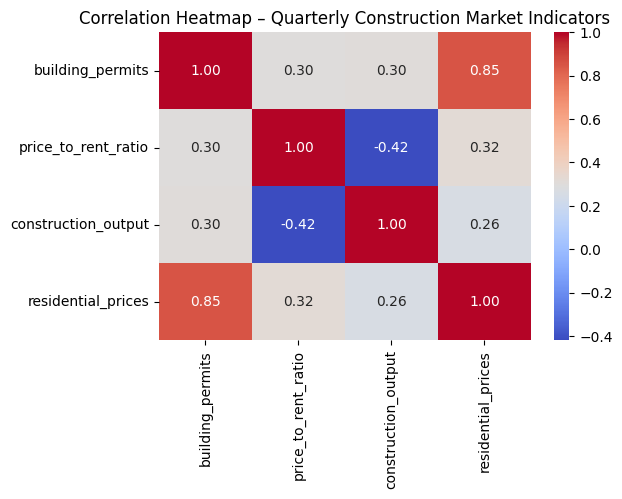

In [18]:
# Load your SQLite quarterly data
df_q = pd.read_sql("SELECT * FROM market_data_quarterly", conn)

# Only use numerical features
numeric_cols = df_q.select_dtypes(include='number')

# Correlation matrix
corr = numeric_cols.corr()

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap – Quarterly Construction Market Indicators")
plt.show()

Conclusions:
1. Building permits & Residential prices --> Strong positive relationship. When prices go up, permits do too. This is useful for predicting!
2. Building permits & Price-to-rent ratio --> Weak-to-moderate positive correlation. Maybe secondary.
3. Building permits & Construction output --> Same — not strongly related in this time frame.
4. Construction output & Price-to-rent ratio --> Negative relationship — when price-to-rent rises, output drops.

---

## Linear Regression - Predicting Building Permits based on All the features

Linear Regression – All Features
R² Score: 0.84
Root Mean Squared Error: 1759.63


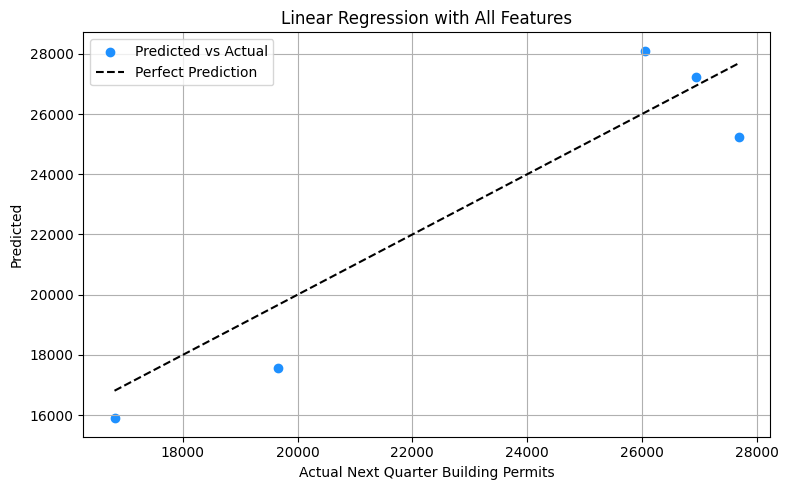

Linear Regression Coefficients:
residential_prices     606.344529
construction_output    293.576408
price_to_rent_ratio    -70.342585
dtype: float64


In [37]:

# Same features as Random Forest (all except datetime, building_permits, target)
X = df.drop(columns=["datetime", "target", "building_permits"])
y = df["target"]

# Same split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Linear Regression – All Features")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.2f}")
print(f"Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred_lr):.2f}")

# Predicted vs Actual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_lr, color='dodgerblue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect Prediction')
plt.xlabel("Actual Next Quarter Building Permits")
plt.ylabel("Predicted")
plt.title("Linear Regression with All Features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Get coefficients
coefficients = pd.Series(lr.coef_, index=X.columns)

# Print
print("Linear Regression Coefficients:")
print(coefficients.sort_values(ascending=False))





## Linear Regression - Predicting Building Permits based on Residential Property Prices

 Linear Regression – Predicting Next Quarter's Building Permits
R² Score: 0.95
Root Mean Squared Error: 955.68


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


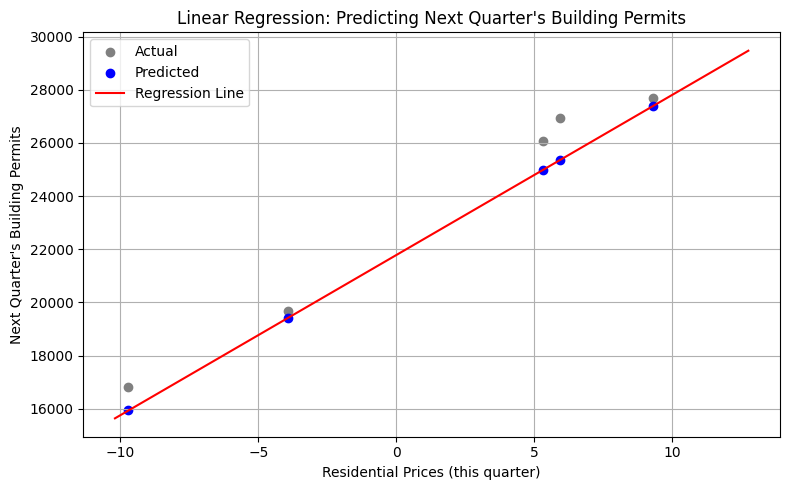

\ Live Forecast – Next Quarter's Building Permits (Linear Regression):
20,236 permits based on residential price of -2.56


In [42]:
# Load and clean data
df = pd.read_sql("SELECT * FROM market_data_quarterly", conn)
df = df.dropna()

# Shift building_permits to simulate predicting next quarter
df["target"] = df["building_permits"].shift(-1)
df = df.dropna()

# Feature and target (univariate model)
X = df[["residential_prices"]]
y = df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation
print(" Linear Regression – Predicting Next Quarter's Building Permits")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred):.2f}")

# === Plot predicted vs actual ===
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, label="Actual", color='gray')
plt.scatter(X_test, y_pred, label="Predicted", color='blue')

# Regression line
x_line = np.linspace(X["residential_prices"].min(), X["residential_prices"].max(), 100).reshape(-1, 1)
y_line = lr.predict(x_line)
plt.plot(x_line, y_line, color='red', label="Regression Line")

plt.xlabel("Residential Prices (this quarter)")
plt.ylabel("Next Quarter's Building Permits")
plt.title("Linear Regression: Predicting Next Quarter's Building Permits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === LIVE PREDICTION ===
latest_valid_row = pd.read_sql(
    "SELECT * FROM market_data_quarterly WHERE residential_prices IS NOT NULL ORDER BY datetime DESC LIMIT 1",
    conn
)

X_live = latest_valid_row[["residential_prices"]]
predicted_live = lr.predict(X_live)[0]

print("\ Live Forecast – Next Quarter's Building Permits (Linear Regression):")
print(f"{int(predicted_live):,} permits based on residential price of {X_live.iloc[0, 0]}")


Conclusions: 

A univariate linear regression using only residential prices as the predictor performed remarkably well, achieving an R² score of 0.95 and a root mean squared error (RMSE) of approximately 955. This suggests that residential prices are a strong leading indicator of upcoming building permit volumes. In contrast, a multivariate linear regression using residential prices, construction output, and the price-to-rent ratio achieved a lower R² of 0.84 and a higher RMSE of around 1,759. While still a solid model, the added features did not improve prediction accuracy and may have introduced noise or collinearity. The coefficients confirmed the expected economic relationships: residential prices and construction output had positive influence, while the price-to-rent ratio was negatively associated with future permits.

These findings demonstrate that, in this dataset, simpler models with carefully chosen predictors can outperform more complex alternatives. They also confirm the practical value of residential prices as a forecasting tool for the construction sector—an insight that could inform business planning for companies like Zehnder, whose performance is closely tied to building volume.

### Creating a table in our SQL Database to store predicted values for next quarter's building permits count based on current residential prices

Mock SQL Schema
```sql
CREATE TABLE IF NOT EXISTS building_permit_predictions (
    current_quarter DATE PRIMARY KEY,
    residential_price REAL,
    predicted_permits INTEGER,
    actual_permits INTEGER
);


In [44]:
# 1. Create table
conn.execute("""
CREATE TABLE IF NOT EXISTS building_permit_predictions (
    current_quarter DATE PRIMARY KEY,
    residential_price REAL,
    predicted_permits INTEGER,
    actual_permits INTEGER
)
""")

# 2. Extract inputs from latest row
current_quarter = latest_valid_row["datetime"].values[0]
res_price = float(X_live.iloc[0, 0])
predicted_val = int(predicted_live)

# 3. Insert or update the prediction row
conn.execute("""
INSERT OR REPLACE INTO building_permit_predictions (current_quarter, residential_price, predicted_permits)
VALUES (?, ?, ?)
""", (current_quarter, res_price, predicted_val))

conn.commit()

print(f"\nSaved prediction for {current_quarter}: {predicted_val:,} permits (residential price: {res_price})")



Saved prediction for 2024-06-30 00:00:00: 20,236 permits (residential price: -2.56)


In [45]:
df_preds = pd.read_sql("SELECT * FROM building_permit_predictions ORDER BY current_quarter", conn)
display(df_preds)


,current_quarter,residential_price,predicted_permits,actual_permits
0,2024-06-30 00:00:00,-2.56,20236,None


Function to backfill actual permits when data becomes available:

In [48]:
def update_actual_permits_from_market_data():
    # Step 1: Get all prediction rows without actuals
    missing_actuals = pd.read_sql("""
        SELECT current_quarter, predicted_permits
        FROM building_permit_predictions
        WHERE actual_permits IS NULL
    """, conn)

    if missing_actuals.empty:
        print("All predictions already have actual permit values.")
        return

    updated = 0

    for _, row in missing_actuals.iterrows():
        curr_q = row["current_quarter"]

        # Step 2: Find the NEXT quarter in market_data_quarterly
        next_q_row = pd.read_sql(f"""
            SELECT building_permits
            FROM market_data_quarterly
            WHERE datetime > '{curr_q}'
            ORDER BY datetime ASC
            LIMIT 1
        """, conn)

        # Step 3: If available, update the prediction row
        if not next_q_row.empty:
            actual = int(next_q_row["building_permits"].values[0])

            conn.execute("""
                UPDATE building_permit_predictions
                SET actual_permits = ?
                WHERE current_quarter = ?
            """, (actual, curr_q))
            updated += 1

    conn.commit()

    print(f" Updated {updated} predictions with actual permit values.")

# Run the update
update_actual_permits_from_market_data()


All predictions already have actual permit values.


## Random Forest Regressor with All the Features

🌲 Random Forest Regressor – Predicting Next Quarter's Building Permits
R² Score: 0.86
Root Mean Squared Error: 1659.16


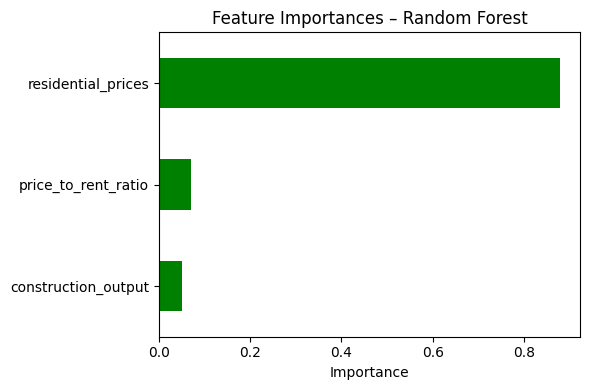

In [28]:
# Load and clean data
df = pd.read_sql("SELECT * FROM market_data_quarterly", conn)
df = df.dropna()

# Shift target to simulate predicting next quarter
df["target"] = df["building_permits"].shift(-1)
df = df.dropna()

# Define features (exclude datetime + target itself)
X = df.drop(columns=["datetime", "target", "building_permits"])
y = df["target"]

# Train/test split (default random split, can be swapped for time-based if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluation
print("🌲 Random Forest Regressor – Predicting Next Quarter's Building Permits")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred):.2f}")

# Feature importance plot
plt.figure(figsize=(6, 4))
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title="Feature Importances – Random Forest", color='green')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Conclusions: 
The model explains 86% of the variance in building permits for the next quarter. This means the Random Forest captured non-linear patterns in the data using multiple features.
Slightly lower performance than the univariate linear regression (R² = 0.95), possibly indicating that linear relationships dominate in this case.
The Random Forest Model with all features is off by ~1660 permits on average. (Higher error than the Linear Regression Model) This suggests that adding more features didn’t help here — maybe even added noise or overfitting.

## Prophet

21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


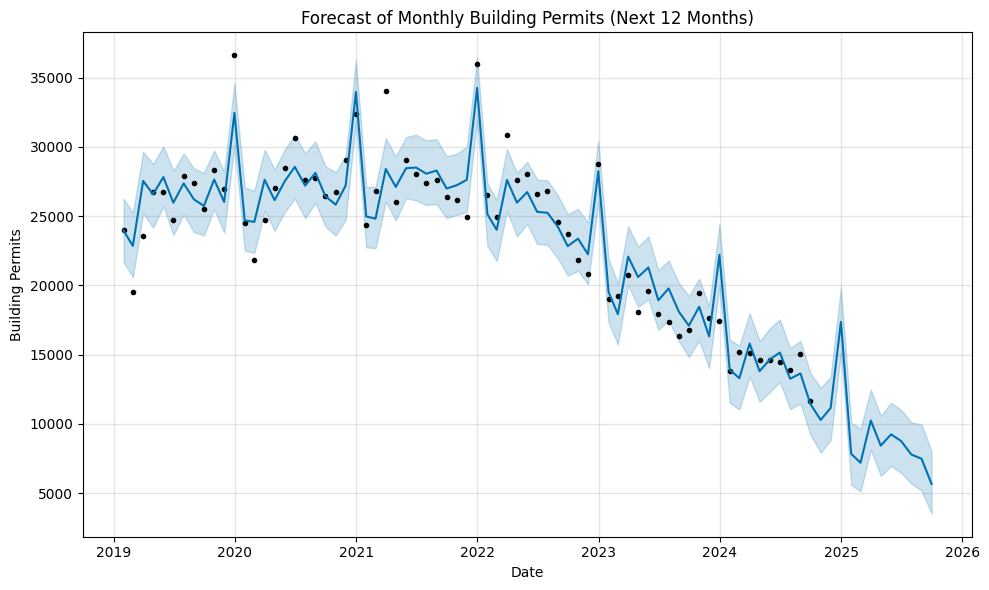

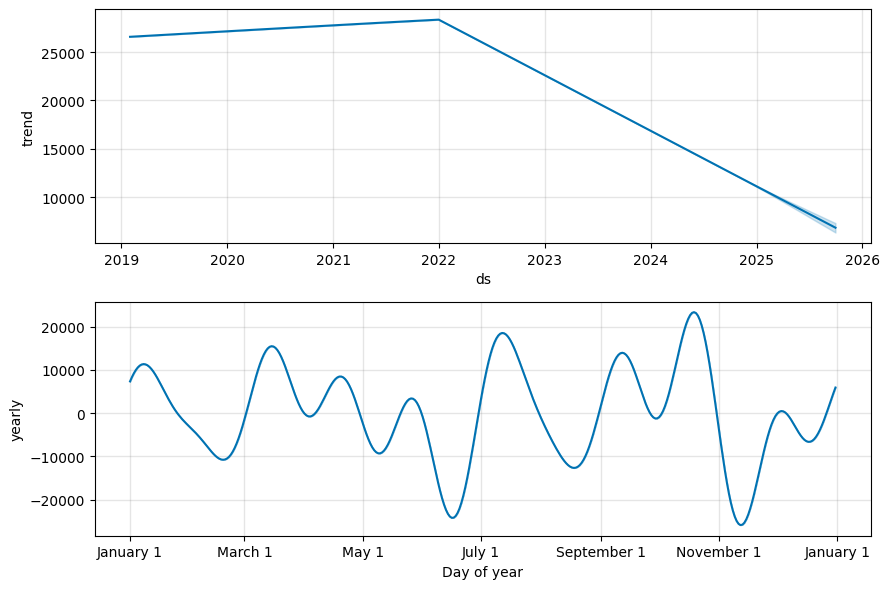

In [31]:
# Load monthly data
df_monthly = pd.read_sql("SELECT datetime, building_permits FROM market_data_monthly", conn)

# Clean and rename for Prophet
df_prophet = df_monthly.rename(columns={"datetime": "ds", "building_permits": "y"})
df_prophet = df_prophet.dropna()

# Fit Prophet model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe: 12 months ahead
future = model.make_future_dataframe(periods=12, freq='M')

# Predict
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Forecast of Monthly Building Permits (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Building Permits")
plt.tight_layout()
plt.show()

# Optional: Plot trend & seasonality components
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()